# Augmentation
**"CutMix, Mixup기법을  적용해보는 프로젝트"**

#### 목차
1. Augmentation을 이용한 데이터셋 만들기
2. 모델 만들기
3. 모델 훈련하기
4. 훈련 과정 시각화하기
5. Augmentation에 의한 모델 성능 비교

#### 모듈

In [1]:
# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt

import tensorflow_datasets as tfds

---
## 1. Augmentation을 이용한 데이터셋 만들기

### 1-1. 데이터 불러오기
- tf dataset의 stanford_dogs 이용

In [2]:
(ds_train, ds_test), ds_info = tfds.load(
    'stanford_dogs',
    split=['train', 'test'],
    as_supervised=True,
    shuffle_files=True,
    with_info=True,
)

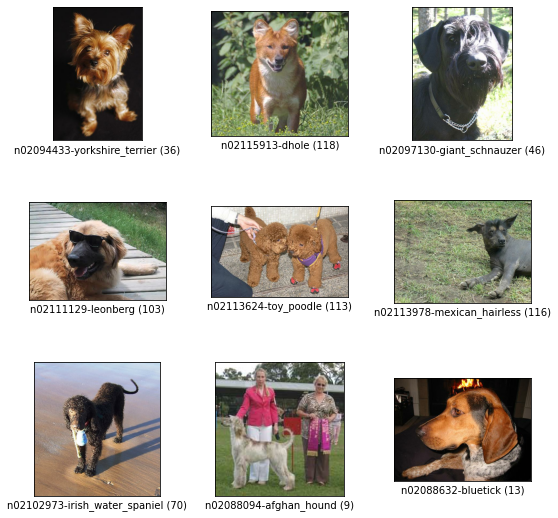

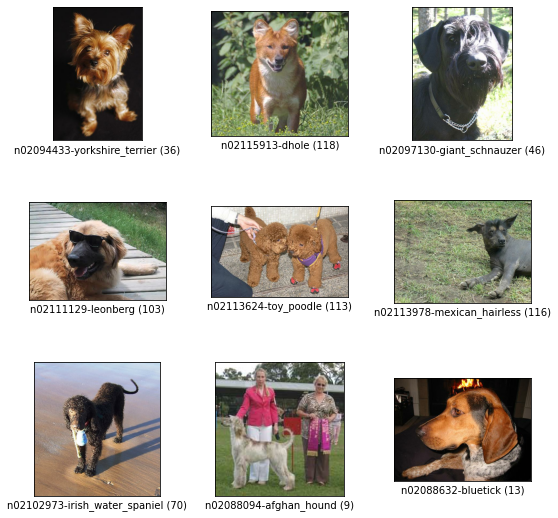

In [3]:
tfds.show_examples(ds_train, ds_info)

## 1-2 Augmentation 적용

In [4]:
# 입력받은 이미지를 float32로 normalize하고 resize한다. 기본적인 전처리
def normalize_and_resize_img(image, label):
    # Normalizes images: `uint8` -> `float32`
    image = tf.image.resize(image, [224, 224])
    return tf.cast(image, tf.float32) / 255., label

# random_flip_left_right(), random_brightness()
def augment(image, label):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_brightness(image, max_delta=0.2)
    image = tf.clip_by_value(image, 0, 1)
    return image, label

# 데이터셋 가공
def apply_normalize_on_dataset(ds, is_test=False, batch_size=16, with_aug=False):
    ds = ds.map(
        normalize_and_resize_img, 
        num_parallel_calls=2
    )
    if not is_test and with_aug:
        ds = ds.map(
            augment
        )
    ds = ds.batch(batch_size)
    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds

print('=3')

=3


In [5]:
ds_train_no_aug = apply_normalize_on_dataset(ds_train, with_aug=False)

### 1-3 CutMix 기법
- 이미지의 일정 영역을 잘라서 다른 이미지에 붙여주는 기법

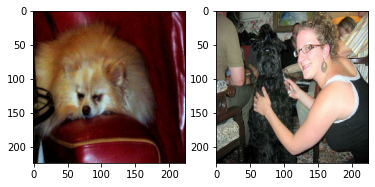

In [6]:
import matplotlib.pyplot as plt

# 데이터셋에서 이미지 2개를 가져옵니다. 
for i, (image, label) in enumerate(ds_train_no_aug.take(1)):
    if i == 0:
        image_a = image[0]
        image_b = image[1]
        label_a = label[0]
        label_b = label[1]
        break

plt.subplot(1,2,1)
plt.imshow(image_a)

plt.subplot(1,2,2)
plt.imshow(image_b)

plt.show()

In [7]:
# a에 삽입될 영역의 바운딩 박스의 위치를 결정하는 함수
def get_clip_box(image_a, image_b):
    # image.shape = (height, width, channel)
    image_size_x = image_a.shape[1]
    image_size_y = image_a.shape[0]
    
    # get center of box
    x = tf.cast(tf.random.uniform([], 0, image_size_x), tf.int32)
    y = tf.cast(tf.random.uniform([], 0, image_size_y), tf.int32)

    # get width, height of box
    width = tf.cast(image_size_x*tf.math.sqrt(1-tf.random.uniform([], 0, 1)), tf.int32)
    height = tf.cast(image_size_y*tf.math.sqrt(1-tf.random.uniform([], 0, 1)), tf.int32)
    
    # clip box in image and get minmax bbox
    x_min = tf.math.maximum(0, x-width//2)
    y_min = tf.math.maximum(0, y-height//2)
    x_max = tf.math.minimum(image_size_x, x+width//2)
    y_max = tf.math.minimum(image_size_y, y+width//2)
    
    return x_min, y_min, x_max, y_max

x_min, y_min, x_max, y_max = get_clip_box(image_a, image_b)

print('x : ', x_min, x_max)
print('y : ', y_min, y_max)

x :  tf.Tensor(121, shape=(), dtype=int32) tf.Tensor(217, shape=(), dtype=int32)
y :  tf.Tensor(0, shape=(), dtype=int32) tf.Tensor(125, shape=(), dtype=int32)


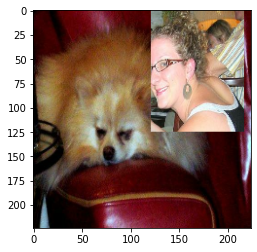

In [8]:
#바탕이미지 a 에서 바운딩 박스 바깥쪽 영역을, 다른 이미지 b 에서 바운딩 박스 안쪽 영역을 가져와서 합치는 함수
def mix_2_images(image_a, image_b, x_min, y_min, x_max, y_max):
    image_size_x = image_a.shape[1]
    image_size_y = image_a.shape[0] 
    middle_left = image_a[y_min:y_max, 0:x_min, :] # image_b의 왼쪽 바깥 영역
    middle_center = image_b[y_min:y_max, x_min:x_max, :]  # image_b의 안쪽 영역
    middle_right = image_a[y_min:y_max, x_max:image_size_x, :] # image_b의 오른쪽 바깥 영역
    middle = tf.concat([middle_left,middle_center,middle_right], axis=1)
    top = image_a[0:y_min, :, :]
    bottom = image_a[y_max:image_size_y, :, :]
    mixed_img = tf.concat([top, middle, bottom],axis=0)
    
    return mixed_img

mixed_img = mix_2_images(image_a, image_b, x_min, y_min, x_max, y_max)
plt.imshow(mixed_img.numpy())
plt.show()

In [9]:
# 섞인 이미지의 면적에 따라 라벨을 섞는 함수
def mix_2_labels(label_a, label_b, x_min, y_min, x_max, y_max, num_classes=120):
    image_size_x = image_a.shape[1]
    image_size_y = image_a.shape[0] 
    mixed_area = (x_max-x_min)*(y_max-y_min)
    total_area = image_size_x*image_size_y
    ratio = tf.cast(mixed_area/total_area, tf.float32)

    if len(label_a.shape)==0:
        label_a = tf.one_hot(label_a, num_classes)
    if len(label_b.shape)==0:
        label_b = tf.one_hot(label_b, num_classes)
    mixed_label = (1-ratio)*label_a + ratio*label_b
    return mixed_label

mixed_label = mix_2_labels(label_a, label_b, x_min, y_min, x_max, y_max)
mixed_label

<tf.Tensor: shape=(120,), dtype=float32, numpy=
array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.23915817, 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.     

In [10]:
# mix_2_images(), mix_2_labels() 를 통해 cutmix()구현
def cutmix(image, label, prob=1.0, batch_size=16, img_size=224, num_classes=120):
    mixed_imgs = []
    mixed_labels = []

    for i in range(batch_size):
        image_a = image[i]
        label_a = label[i]
        j = tf.cast(tf.random.uniform([],0, batch_size),tf.int32)
        image_b = image[j]
        label_b = label[j]
        x_min, y_min, x_max, y_max = get_clip_box(image_a, image_b)
        mixed_imgs.append(mix_2_images(image_a, image_b, x_min, y_min, x_max, y_max))
        mixed_labels.append(mix_2_labels(label_a, label_b, x_min, y_min, x_max, y_max))

    mixed_imgs = tf.reshape(tf.stack(mixed_imgs), (batch_size, img_size, img_size, 3))
    mixed_labels = tf.reshape(tf.stack(mixed_labels), (batch_size, num_classes))
    return mixed_imgs, mixed_labels

print('=3')

=3


### 1-4 Mixup 기법
- 두 개 이미지의 픽셀별 값을 비율에 따라 섞어주는 기법

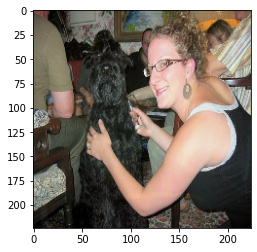

tf.Tensor(
[0.       0.       0.       0.       0.       0.       0.       0.
 0.       0.       0.       0.       0.       0.       0.       0.
 0.       0.       0.       0.       0.       0.       0.       0.
 0.       0.       0.       0.       0.       0.       0.       0.
 0.       0.       0.       0.       0.       0.       0.       0.
 0.       0.       0.       0.       0.       0.       0.933056 0.
 0.       0.       0.       0.       0.       0.       0.       0.
 0.       0.       0.       0.       0.       0.       0.       0.
 0.       0.       0.       0.       0.       0.       0.       0.
 0.       0.       0.       0.       0.       0.       0.       0.
 0.       0.       0.       0.       0.       0.       0.       0.
 0.       0.       0.       0.       0.       0.       0.       0.
 0.       0.       0.       0.       0.       0.       0.       0.
 0.       0.       0.       0.066944 0.       0.       0.       0.
 0.       0.       0.       0.       0.       0.   

In [11]:
num_classes = ds_info.features["label"].num_classes

# function for mixup
def mixup_2_images(image_a, image_b, label_a, label_b):
    ratio = tf.random.uniform([], 0, 1)
    
    if len(label_a.shape)==0:
        label_a = tf.one_hot(label_a, num_classes)
    if len(label_b.shape)==0:
        label_b = tf.one_hot(label_b, num_classes)
    mixed_image= (1-ratio)*image_a + ratio*image_b
    mixed_label = (1-ratio)*label_a + ratio*label_b
    
    return mixed_image, mixed_label

mixed_img, mixed_label = mixup_2_images(image_a, image_b, label_a, label_b)
plt.imshow(mixed_img.numpy())
plt.show()
print(mixed_label)

In [12]:
def mixup(image, label, prob=1.0, batch_size=16, img_size=224, num_classes=120):
    mixed_imgs = []
    mixed_labels = []

    for i in range(batch_size):
        image_a = image[i]
        label_a = label[i]
        j = tf.cast(tf.random.uniform([],0,batch_size), tf.int32)
        image_b = image[j]
        label_b = label[j]
        mixed_img, mixed_label = mixup_2_images(image_a, image_b, label_a, label_b)
        mixed_imgs.append(mixed_img)
        mixed_labels.append(mixed_label)

    mixed_imgs = tf.reshape(tf.stack(mixed_imgs), (batch_size, img_size, img_size, 3))
    mixed_labels = tf.reshape(tf.stack(mixed_labels), (batch_size, num_classes))
    return mixed_imgs, mixed_labels

print('=3')

=3


### 1-5 새로운 데이터셋 만들기

In [13]:
def onehot(image, label) :
    label = tf.one_hot(label, num_classes)
    return image, label

In [14]:
# CutMix와 Mixup 적용
def apply_normalize_on_dataset(ds, is_test=False, batch_size=16, with_aug=False, with_cutmix=False, with_mixup=False):
    ds = ds.map(
        normalize_and_resize_img, 
        num_parallel_calls=2
    )
    if not is_test and with_aug:
        ds = ds.map(
            augment
        )
    ds = ds.batch(batch_size)
    if not is_test and with_cutmix:
        ds = ds.map(
            cutmix,
            num_parallel_calls=2
        )
    elif not is_test and with_mixup:
        ds = ds.map(
            mixup,
            num_parallel_calls=2
        )
    else:
        ds = ds.map(
            onehot,
            num_parallel_calls=2
        )
    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds

In [15]:
# 데이터 생성
ds_train_no_aug = apply_normalize_on_dataset(ds_train, with_aug=False)
ds_train_aug = apply_normalize_on_dataset(ds_train, with_aug=True)
ds_train_cutmix = apply_normalize_on_dataset(ds_train, with_cutmix=True)
ds_train_mixup = apply_normalize_on_dataset(ds_train, with_mixup=True)
ds_test = apply_normalize_on_dataset(ds_test, is_test = True)

---
## 2. 모델 만들기
- ResNet50

In [16]:
# imagenet 데이터에 훈련된 ResNet50 모델 불러오기
resnet50_no_aug = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,   # 마지막 fully connected layer 미포함
        weights='imagenet',
        input_shape=(224, 224, 3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation = 'softmax')  # 데이터에 맞는 FC layer 붙여서 활용
])

In [17]:
resnet50_aug = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224,224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation='softmax')
])

In [18]:
resnet50_cutmix = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224,224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation='softmax')
])

In [19]:
resnet50_mixup = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224,224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation='softmax')
])

---
## 3. 모델 훈련하기

In [22]:
EPOCH = 10

resnet50_no_aug.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01),
    metrics=['accuracy'],
)

resnet50_aug.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01),
    metrics=['accuracy'],
)

resnet50_cutmix.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01),
    metrics=['accuracy'],
)

resnet50_mixup.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01),
    metrics=['accuracy'],
)

In [23]:
history_resnet50_no_aug = resnet50_no_aug.fit(
    ds_train_no_aug, 
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/10
750/750 [==============================] - 352s 459ms/step - loss: 0.7542 - accuracy: 0.8005 - val_loss: 1.1702 - val_accuracy: 0.6617
Epoch 2/10
750/750 [==============================] - 342s 457ms/step - loss: 0.3790 - accuracy: 0.9054 - val_loss: 1.0207 - val_accuracy: 0.7028
Epoch 3/10
750/750 [==============================] - 343s 457ms/step - loss: 0.1046 - accuracy: 0.9864 - val_loss: 0.9221 - val_accuracy: 0.7346
Epoch 4/10
750/750 [==============================] - 342s 457ms/step - loss: 0.0370 - accuracy: 0.9983 - val_loss: 0.9225 - val_accuracy: 0.7376
Epoch 5/10
750/750 [==============================] - 343s 457ms/step - loss: 0.0367 - accuracy: 0.9967 - val_loss: 0.9598 - val_accuracy: 0.7278
Epoch 6/10
750/750 [==============================] - 343s 457ms/step - loss: 0.0173 - accuracy: 0.9990 - val_loss: 0.9408 - val_accuracy: 0.7373
Epoch 7/10
750/750 [==============================] - 343s 457ms/step - loss: 0.0102 - accuracy: 1.0000 - val_loss: 0.9645 -

In [24]:
history_resnet50_aug = resnet50_aug.fit(
    ds_train_aug, 
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/10
750/750 [==============================] - 350s 457ms/step - loss: 3.3045 - accuracy: 0.2668 - val_loss: 2.9241 - val_accuracy: 0.2857
Epoch 2/10
750/750 [==============================] - 342s 456ms/step - loss: 1.0811 - accuracy: 0.6961 - val_loss: 1.3455 - val_accuracy: 0.6186
Epoch 3/10
750/750 [==============================] - 342s 456ms/step - loss: 0.5835 - accuracy: 0.8381 - val_loss: 1.1338 - val_accuracy: 0.6756
Epoch 4/10
750/750 [==============================] - 343s 457ms/step - loss: 0.3146 - accuracy: 0.9207 - val_loss: 1.1107 - val_accuracy: 0.6783
Epoch 5/10
750/750 [==============================] - 342s 457ms/step - loss: 0.1707 - accuracy: 0.9640 - val_loss: 0.9721 - val_accuracy: 0.7260
Epoch 6/10
750/750 [==============================] - 343s 457ms/step - loss: 0.1049 - accuracy: 0.9804 - val_loss: 1.0909 - val_accuracy: 0.7018
Epoch 7/10
750/750 [==============================] - 342s 456ms/step - loss: 0.0629 - accuracy: 0.9903 - val_loss: 1.0156 -

In [25]:
history_resnet50_cutmix = resnet50_cutmix.fit(
    ds_train_cutmix, 
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/10
750/750 [==============================] - 353s 461ms/step - loss: 4.3752 - accuracy: 0.1048 - val_loss: 3.5612 - val_accuracy: 0.1838
Epoch 2/10
750/750 [==============================] - 344s 459ms/step - loss: 3.0706 - accuracy: 0.4052 - val_loss: 1.4212 - val_accuracy: 0.6095
Epoch 3/10
750/750 [==============================] - 344s 459ms/step - loss: 2.7080 - accuracy: 0.5082 - val_loss: 1.3785 - val_accuracy: 0.6177
Epoch 4/10
750/750 [==============================] - 344s 459ms/step - loss: 2.5003 - accuracy: 0.5826 - val_loss: 1.2357 - val_accuracy: 0.6603
Epoch 5/10
750/750 [==============================] - 344s 459ms/step - loss: 2.3211 - accuracy: 0.6439 - val_loss: 1.4884 - val_accuracy: 0.6041
Epoch 6/10
750/750 [==============================] - 344s 459ms/step - loss: 2.2099 - accuracy: 0.6736 - val_loss: 1.1162 - val_accuracy: 0.6915
Epoch 7/10
750/750 [==============================] - 344s 459ms/step - loss: 2.0854 - accuracy: 0.7067 - val_loss: 1.3709 -

In [26]:
history_resnet50_mixup = resnet50_mixup.fit(
    ds_train_mixup, 
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/10
750/750 [==============================] - 351s 460ms/step - loss: 4.2331 - accuracy: 0.1431 - val_loss: 4.4046 - val_accuracy: 0.0812
Epoch 2/10
750/750 [==============================] - 344s 458ms/step - loss: 2.9421 - accuracy: 0.4475 - val_loss: 1.3204 - val_accuracy: 0.6260
Epoch 3/10
750/750 [==============================] - 344s 458ms/step - loss: 2.5939 - accuracy: 0.5744 - val_loss: 1.3044 - val_accuracy: 0.6353
Epoch 4/10
750/750 [==============================] - 343s 458ms/step - loss: 2.4287 - accuracy: 0.6457 - val_loss: 1.2500 - val_accuracy: 0.6493
Epoch 5/10
750/750 [==============================] - 344s 458ms/step - loss: 2.2890 - accuracy: 0.6927 - val_loss: 1.2572 - val_accuracy: 0.6583
Epoch 6/10
750/750 [==============================] - 344s 458ms/step - loss: 2.1790 - accuracy: 0.7351 - val_loss: 1.1776 - val_accuracy: 0.6823
Epoch 7/10
750/750 [==============================] - 344s 458ms/step - loss: 2.0875 - accuracy: 0.7662 - val_loss: 1.2350 -

---
## 4. 시각화

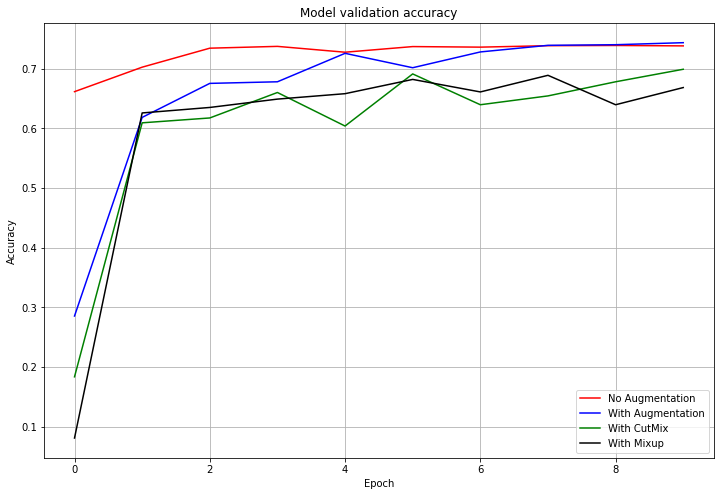

In [27]:
plt.figure(figsize=(12, 8))
plt.plot(history_resnet50_no_aug.history['val_accuracy'], 'r')
plt.plot(history_resnet50_aug.history['val_accuracy'], 'b')
plt.plot(history_resnet50_cutmix.history['val_accuracy'], 'g')
plt.plot(history_resnet50_mixup.history['val_accuracy'], 'k')
plt.title('Model validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['No Augmentation', 'With Augmentation', 'With CutMix', 'With Mixup'], loc='lower right')
plt.grid(True)
plt.show()

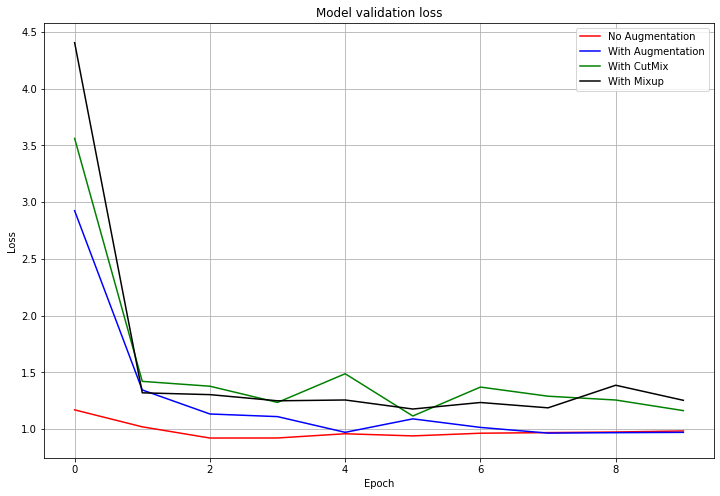

In [28]:
plt.figure(figsize=(12, 8))
plt.plot(history_resnet50_no_aug.history['val_loss'], 'r')
plt.plot(history_resnet50_aug.history['val_loss'], 'b')
plt.plot(history_resnet50_cutmix.history['val_loss'], 'g')
plt.plot(history_resnet50_mixup.history['val_loss'], 'k')
plt.title('Model validation loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['No Augmentation', 'With Augmentation', 'With CutMix', 'With Mixup'], loc='upper right')
plt.grid(True)
plt.show()

---
## 5. Augmentation에 의한 모델 성능 비교

In [29]:
import pandas as pd

acc_data = {'No Augmentation': history_resnet50_no_aug.history['val_accuracy'], 
            'With Augmentation': history_resnet50_aug.history['val_accuracy'], 
            'With CutMix': history_resnet50_cutmix.history['val_accuracy'], 
            'With Mixup': history_resnet50_mixup.history['val_accuracy']}
acc_df = pd.DataFrame(acc_data)
acc_df

,No Augmentation,With Augmentation,With CutMix,With Mixup
0,0.661730,0.285681,0.183769,0.081157
1,0.702775,0.618587,0.609492,0.626049
2,0.734608,0.675606,0.617654,0.635261
3,0.737640,0.678288,0.660331,0.649254
4,0.727845,0.725980,0.604128,0.658349
5,0.737290,0.701842,0.691465,0.682253
6,0.736357,0.728312,0.639809,0.661264
7,0.738806,0.739389,0.654618,0.689132
8,0.739156,0.740438,0.678288,0.639809
9,0.738456,0.743820,0.699277,0.668610


- epoch가 커질수록 Augmentation을 진행했을 때 정확도가 향상된다.
- CutMix와 Mixup을 적용하니 오히려 정확도가 감소했다. 데이터셋이 해당 기법에 맞지 않았다고 생각된다.